In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier 

from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split,GridSearchCV,KFold,StratifiedKFold
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [2]:
def feat_prep():
    #Read the data
    df = pd.read_csv('../gtmsa_practicum_datasets/merged_final_data.csv',dtype=str)
    #convert 2 cols Hospital system if independent and if is critical access hospital to one hot encoding
    df['HS Independent ipps'] = 0
    df['HS Independent cah'] = 0
    idx = df['hospital system or, if independent, ipps/cah'] == 'Independent (IPPS)'
    df.loc[idx,'HS Independent ipps'] = 1
    idx = df['hospital system or, if independent, ipps/cah'] == 'Independent (CAH)'
    df.loc[idx,'HS Independent cah'] = 1
    df['HS critical'] = df['is hospital a critical access hospital (y/n)?'].map({'Y': 1, 'N': 0})
    
    #Dropping cols that seems irrelavant for prediction and also columns with more than 35% of missing values
    cols = ['hospital name','street address','city','state','zip code','hospital system or, if independent, ipps/cah','is hospital a critical access hospital (y/n)?']
    for i in df.columns.values:
        if(np.mean(df[i].isnull())>0.65):
            cols.append(i)
#     cols.remove('relative price for inpatient and outpatient services')
    df.drop(columns=cols,inplace=True)
    #Removing % in column
    
    df['relative price for inpatient facility services'] = df['relative price for inpatient facility services'].str.replace('%','',regex=False)
    df['relative price for outpatient facility services'] = df['relative price for outpatient facility services'].str.replace('%','',regex=False)
 
    #Scaling columns that are scalable using Standard Scaler
    cols_not_scaled = ['medicare provider number','HS critical','HS Independent ipps','HS Independent cah','relative price for inpatient and outpatient services']
    cols_scaled = [x for x in df.columns.values if x not in cols_not_scaled]
    
    np.random.seed(101)
    dt = pd.DataFrame(df[cols_scaled])
    scalers = []
    for i in dt.columns.values:
        dt[i] = pd.to_numeric(dt[i])
        if(i not in cols_not_scaled):
#             from sklearn.preprocessing import QuantileTransformer
            scaler = preprocessing.QuantileTransformer().fit(dt[i].values.reshape(-1, 1))
#             scaler = preprocessing.StandardScaler().fit(dt[i].values.reshape(-1, 1))
            dt[i] = scaler.transform(dt[i].values.reshape(-1,1))
            scalers.append(scaler)
        
    #Imputing missing values using knn imputer
    dt.fillna(np.nan,inplace=True)
    imp = KNNImputer(n_neighbors=8, weights="uniform")
    imp.fit(dt)#IterativeImputer(max_iter=42, random_state=24)
    dt = pd.DataFrame(imp.transform(dt),columns=dt.columns.values)
    cols_knn_imp = dt.columns.values
    #Adding not scaled and not imputed columns to the final dataframe as float
    for i in cols_not_scaled:
        dt[i] = pd.to_numeric(df[i])
        
    #Have medicare provider number as the index for the data instead bein one feature. 
    dt.set_index('medicare provider number',inplace=True)
    return dt, imp, scalers, cols_scaled, cols_knn_imp
data, knn_imputer, scalers, cols_scaled, cols_knn_imp = feat_prep()
print(data.shape)

(3329, 52)


In [3]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

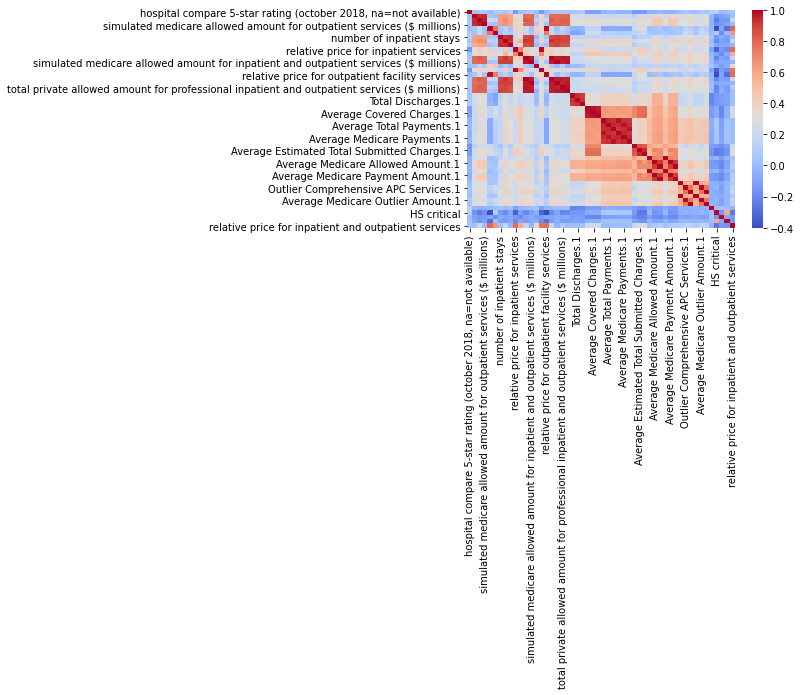

In [4]:
fig, ax = plt.subplots()
sns.heatmap(data.corr(method='pearson'), annot=False, 
            cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('corr_matrix.png', bbox_inches='tight', pad_inches=0.0)

In [5]:
import math
idx = abs(corr.iloc[:,-1])>0.01
print(len(corr[idx].index))
print(corr[idx].index)
cols = ['hospital compare 5-star rating (october 2018, na=not available)',
       'number of outpatient services',
       'total private allowed amount for outpatient services ($ millions)',
       'simulated medicare allowed amount for outpatient services ($ millions)',
       'relative price for outpatient services',
       'standardized price per outpatient service',
       'number of inpatient stays',
       'simulated medicare allowed amount for inpatient services ($ millions)',
       'relative price for inpatient services',
       'standardized price per inpatient stay',
       'total private allowed amount for inpatient and outpatient services ($ millions)',
       'simulated medicare allowed amount for inpatient and outpatient services ($ millions)',
       'relative price for professional inpatient and outpatient services',
       'relative price for inpatient facility services',
       'relative price for outpatient facility services',
       'total private allowed amount for facility inpatient and outpatient services ($ millions)',
       'simulated medicare allowed amount for facility inpatient and outpatient services ($ millions)',
       'simulated medicare allowed amount for professional inpatient and outpatient services ($ millions)',
       'Total Discharges.1', 'Average Covered Charges.1','Average Total Payments.1',
       'Average Medicare Payments', 
       'Average Estimated Total Submitted Charges.2',
       'Average Medicare Allowed Amount.2',
       'Average Medicare Payment Amount.2',
       'Outlier Comprehensive APC Services',
       'Outlier Comprehensive APC Services.1',
       'Outlier Comprehensive APC Services.2',
       'Average Medicare Outlier Amount', 'Average Medicare Outlier Amount.1',
       'Average Medicare Outlier Amount.2', 'HS critical',
       'HS Independent ipps', 'HS Independent cah',
       'relative price for inpatient and outpatient services']
data = data[cols]

49
Index(['hospital compare 5-star rating (october 2018, na=not available)',
       'number of outpatient services',
       'total private allowed amount for outpatient services ($ millions)',
       'simulated medicare allowed amount for outpatient services ($ millions)',
       'relative price for outpatient services',
       'standardized price per outpatient service',
       'number of inpatient stays',
       'total private allowed amount for inpatient services ($ millions)',
       'simulated medicare allowed amount for inpatient services ($ millions)',
       'relative price for inpatient services',
       'standardized price per inpatient stay',
       'total private allowed amount for inpatient and outpatient services ($ millions)',
       'simulated medicare allowed amount for inpatient and outpatient services ($ millions)',
       'relative price for professional inpatient and outpatient services',
       'relative price for inpatient facility services',
       'relative pri

In [6]:
# filter to only labeled data
idx = data['relative price for inpatient and outpatient services'].isnull()
dt = data[~idx]
print(dt.shape)
dt.head()

(1628, 35)


,"hospital compare 5-star rating (october 2018, na=not available)",number of outpatient services,total private allowed amount for outpatient services ($ millions),simulated medicare allowed amount for outpatient services ($ millions),relative price for outpatient services,standardized price per outpatient service,number of inpatient stays,simulated medicare allowed amount for inpatient services ($ millions),relative price for inpatient services,standardized price per inpatient stay,...,Outlier Comprehensive APC Services,Outlier Comprehensive APC Services.1,Outlier Comprehensive APC Services.2,Average Medicare Outlier Amount,Average Medicare Outlier Amount.1,Average Medicare Outlier Amount.2,HS critical,HS Independent ipps,HS Independent cah,relative price for inpatient and outpatient services
medicare provider number,,,,,,,,,,,,,,,,,,,,,
10006,0.471471,0.475475,0.263764,0.284785,0.280280,0.105110,0.458959,0.251752,0.674675,0.461141,...,0.000000,0.385021,0.398357,0.000000,0.403900,0.428722,0,0,0,241.0
10029,0.772272,0.754628,0.714715,0.775275,0.147147,0.061974,0.424925,0.332833,0.440440,0.189258,...,0.322072,0.258640,0.467900,0.319548,0.276453,0.474102,0,0,0,174.0
10033,0.197698,0.680681,0.705205,0.685185,0.650150,0.470236,0.482482,0.583584,0.918919,0.947508,...,0.388291,0.438770,0.501363,0.386776,0.426838,0.474036,0,0,0,322.0
10039,0.197698,0.823579,0.786787,0.841341,0.135135,0.068066,0.763764,0.733835,0.864865,0.847639,...,0.124799,0.245680,0.249892,0.120756,0.239575,0.245563,0,0,0,245.0
10056,0.772272,0.453453,0.484484,0.586086,0.138138,0.067234,0.096096,0.090090,0.427427,0.323592,...,0.295093,0.452294,0.427533,0.299030,0.419996,0.421360,0,0,0,174.0


<h1> Classification

In [7]:
# bucket reponse variable into different classes
bucket = np.array([0, 100, 400, np.inf])
cost_category = pd.cut(dt['relative price for inpatient and outpatient services'], bucket, labels = ["low", "medium", "high"])
dt = dt.assign(cost_category = cost_category)

In [8]:
dt.columns.values

array(['hospital compare 5-star rating (october 2018, na=not available)',
       'number of outpatient services',
       'total private allowed amount for outpatient services ($ millions)',
       'simulated medicare allowed amount for outpatient services ($ millions)',
       'relative price for outpatient services',
       'standardized price per outpatient service',
       'number of inpatient stays',
       'simulated medicare allowed amount for inpatient services ($ millions)',
       'relative price for inpatient services',
       'standardized price per inpatient stay',
       'total private allowed amount for inpatient and outpatient services ($ millions)',
       'simulated medicare allowed amount for inpatient and outpatient services ($ millions)',
       'relative price for professional inpatient and outpatient services',
       'relative price for inpatient facility services',
       'relative price for outpatient facility services',
       'total private allowed amount for

In [9]:
# split dataset for train and test
x = dt.loc[:, ~dt.columns.isin(["cost_category","relative price for inpatient and outpatient services"])]
with open('extratrees_regressor.pk','rb') as file:
    extratrees_model, knn_imputer, scalers, cols_scaled, cols_knn_imp = pickle.load(file)
relative_price_pred = extratrees_model.predict(x)
x = x.assign(relative_price_pred = relative_price_pred)
y_data = dt.loc[:, "cost_category"]
# factorize y
labelencoder = preprocessing.LabelEncoder().fit(y_data)
y = labelencoder.transform(y_data)

# split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=102)

In [10]:
print(x)

                          hospital compare 5-star rating (october 2018, na=not available)  \
medicare provider number                                                                    
10006                                                              0.471471                 
10029                                                              0.772272                 
10033                                                              0.197698                 
10039                                                              0.197698                 
10056                                                              0.772272                 
...                                                                     ...                 
360263                                                             0.685936                 
360270                                                             0.659472                 
361309                                                             0.6

In [11]:
print(dt['cost_category'].value_counts())
print(np.unique(y,return_counts=True))

medium    1552
high        59
low         17
Name: cost_category, dtype: int64
(array([0, 1, 2]), array([  59,   17, 1552]))


In [12]:
import warnings
warnings.filterwarnings('ignore')

classification_model_factory = [
 LogisticRegression(),
 SGDClassifier(),
 SVC(),
 KNeighborsClassifier(),
 GaussianNB(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 AdaBoostClassifier(),
 GradientBoostingClassifier(),
 MLPClassifier()
]

for model in classification_model_factory:
    model.seed = 222
    num_folds = 5

    y_pred = cross_val_predict(model, x_train, y_train, cv=num_folds)
    accuracy = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='weighted')
    f1_score = metrics.precision_score(y_train,y_pred, average='weighted')
    score_description = "Accuracy - %0.2f , precision -  %0.2f , f1_score - %0.2f" % (accuracy, precision,f1_score)
    
    print('{model:25} CV-5 Performance: {score}'.format(
     model=model.__class__.__name__,
     score=score_description
     ))

LogisticRegression        CV-5 Performance: Accuracy - 0.97 , precision -  0.97 , f1_score - 0.97
SGDClassifier             CV-5 Performance: Accuracy - 0.96 , precision -  0.91 , f1_score - 0.91
SVC                       CV-5 Performance: Accuracy - 0.98 , precision -  0.97 , f1_score - 0.97
KNeighborsClassifier      CV-5 Performance: Accuracy - 0.99 , precision -  0.99 , f1_score - 0.99
GaussianNB                CV-5 Performance: Accuracy - 0.73 , precision -  0.95 , f1_score - 0.95
DecisionTreeClassifier    CV-5 Performance: Accuracy - 0.99 , precision -  0.99 , f1_score - 0.99
RandomForestClassifier    CV-5 Performance: Accuracy - 0.99 , precision -  0.99 , f1_score - 0.99
AdaBoostClassifier        CV-5 Performance: Accuracy - 0.98 , precision -  0.98 , f1_score - 0.98
GradientBoostingClassifier CV-5 Performance: Accuracy - 0.99 , precision -  0.99 , f1_score - 0.99
MLPClassifier             CV-5 Performance: Accuracy - 0.96 , precision -  0.96 , f1_score - 0.96


In [13]:
def gsFit(clf,param_grid,X,Y,cv,verbose=False,fit_params=None,scoring=None,n_jobs=-1):
    gs = GridSearchCV(clf,param_grid,cv=cv,n_jobs=n_jobs,scoring=scoring,pre_dispatch=8)
    if fit_params is not None:
        gs.fit(X,Y,**fit_params)
    else:
        gs.fit(X,Y)

    if verbose:
        print("Best classifier:")
        print(gs.best_params_)
#         print(gs.cv_results_)

    return gs.best_estimator_

In [14]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        other_class = [x for x in unique_class if x != per_class]

        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        roc_auc = metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

def print_stats(pred,actuals):
    print('Accuracy : ',metrics.accuracy_score(actuals, pred))
    print('Precision : ',metrics.precision_score(actuals, pred,average='weighted'))
    print('Recall/Sensitivity : ',metrics.recall_score(actuals, pred,average='weighted'))
    print('F1 Score : ',metrics.explained_variance_score(actuals, pred))
    roc = roc_auc_score_multiclass(actuals, pred, average='weighted')
    print('ROC AUC score :',roc)
    print('average ROC AUC : ',np.mean(np.fromiter(roc.values(),dtype=float)))
    print('Confusion matrix : ',metrics.confusion_matrix(actuals, pred))
    return

<h1> Decision Tree Classifier

In [15]:
clf = DecisionTreeClassifier(class_weight='balanced',random_state=1010)
param_grid = dict(criterion = ['gini','entropy'],splitter=['best','random'],max_features = ['auto', 'sqrt', 'log2'])
cv = StratifiedKFold(n_splits=8,shuffle=True)
DT_classifier = gsFit(clf,param_grid,x_train,y_train,cv,verbose=True,fit_params=None,scoring='balanced_accuracy',n_jobs=10)
y_pred_on_train = cross_val_predict(DT_classifier, x_train, y_train, cv=8)
y_pred_on_test = DT_classifier.predict(x_test)
print('Decision Tree Classifier')
print('---------Training----------')
print_stats(y_pred_on_train,y_train)
y_pred_on_test = DT_classifier.predict(x_test)
print('----------Testing----------')
print_stats(y_pred_on_test,y_test)

Best classifier:
{'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}
Decision Tree Classifier
---------Training----------
Accuracy :  0.9798165137614679
Precision :  0.9798761748144856
Recall/Sensitivity :  0.9798165137614679
F1 Score :  0.5227700602322977
ROC AUC score : {0: 0.8957345971563981, 1: 0.8072280551389187, 2: 0.8702015355086372}
average ROC AUC :  0.8577213959346514
Confusion matrix :  [[  28    0    7]
 [   0    8    5]
 [   9    1 1032]]
----------Testing----------
Accuracy :  0.9907063197026023
Precision :  0.9903653969283056
Recall/Sensitivity :  0.9907063197026023
F1 Score :  0.884354939721309
ROC AUC score : {0: 0.9980544747081712, 1: 0.749063670411985, 2: 0.9613445378151261}
average ROC AUC :  0.9028208943117608
Confusion matrix :  [[ 24   0   0]
 [  0   2   2]
 [  2   1 507]]


<h1> Random Forest Classifier

In [16]:
clf = RandomForestClassifier(random_state=6567)
param_grid = dict(criterion = ['gini','entropy'],n_estimators=[1,2,5,10,25,50,75,100], bootstrap=[True, False],oob_score=[True, False],class_weight=['balanced','balanced_subsample'])
cv = StratifiedKFold(n_splits=8,shuffle=True)
RF_classifier = gsFit(clf,param_grid,x_train,y_train,cv,verbose=True,fit_params=None,scoring='balanced_accuracy',n_jobs=10)
y_pred_on_train = cross_val_predict(RF_classifier, x_train, y_train, cv=8)
y_pred_on_test = RF_classifier.predict(x_test)
print('Ada Boost Classifier')
print('---------Training----------')
print_stats(y_pred_on_train,y_train)
y_pred_on_test = RF_classifier.predict(x_test)
print('----------Testing----------')
print_stats(y_pred_on_test,y_test)

Best classifier:
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 2, 'oob_score': True}
Ada Boost Classifier
---------Training----------
Accuracy :  0.9642201834862385
Precision :  0.9706839469285139
Recall/Sensitivity :  0.9642201834862385
F1 Score :  0.2693315653517304
ROC AUC score : {0: 0.9200406228842248, 1: 0.7645882436968787, 2: 0.871980966090851}
average ROC AUC :  0.8522032775573182
Confusion matrix :  [[  30    0    5]
 [   0    7    6]
 [  18   10 1014]]
----------Testing----------
Accuracy :  0.9572490706319703
Precision :  0.9665624398026003
Recall/Sensitivity :  0.9572490706319703
F1 Score :  0.25949193674651627
ROC AUC score : {0: 0.9049935149156939, 1: 0.745318352059925, 2: 0.8761904761904762}
average ROC AUC :  0.8421674477220318
Confusion matrix :  [[ 20   0   4]
 [  0   2   2]
 [ 12   5 493]]


<h1> Ada Boost Classifier

In [17]:
clf = AdaBoostClassifier(base_estimator=DT_classifier,random_state=100)
param_grid = dict(algorithm = ['SAMME','SAMME.R'],n_estimators=[1,2,5,10,25,50,75,100],learning_rate = np.linspace(0.00000000001,10,16))
cv = StratifiedKFold(n_splits=8,shuffle=True)
AB_classifier = gsFit(clf,param_grid,x_train,y_train,cv,verbose=True,fit_params=None,scoring='balanced_accuracy',n_jobs=10)
y_pred_on_train = cross_val_predict(AB_classifier, x_train, y_train, cv=8)
y_pred_on_test = AB_classifier.predict(x_test)
print('Ada Boost Classifier')
print('---------Training----------')
print_stats(y_pred_on_train,y_train)
y_pred_on_test = AB_classifier.predict(x_test)
print('----------Testing----------')
print_stats(y_pred_on_test,y_test)

Best classifier:
{'algorithm': 'SAMME', 'learning_rate': 1e-11, 'n_estimators': 1}
Ada Boost Classifier
---------Training----------
Accuracy :  0.9706422018348624
Precision :  0.9694228435512839
Recall/Sensitivity :  0.9706422018348624
F1 Score :  0.41529012202825843
ROC AUC score : {0: 0.8119160460392687, 1: 0.7275194628955075, 2: 0.7859085092770314}
average ROC AUC :  0.7751146727372692
Confusion matrix :  [[  22    0   13]
 [   0    6    7]
 [   5    7 1030]]
----------Testing----------
Accuracy :  0.9776951672862454
Precision :  0.9776928853558151
Recall/Sensitivity :  0.9776951672862454
F1 Score :  0.5898504775324878
ROC AUC score : {0: 0.8720817120622568, 1: 0.87312734082397, 2: 0.8700980392156863}
average ROC AUC :  0.8717690307006377
Confusion matrix :  [[ 18   0   6]
 [  0   3   1]
 [  3   2 505]]


<h1>Gradient Boosting Classifier

In [18]:
clf = GradientBoostingClassifier(random_state=1010)
param_grid = dict(loss=['deviance','exponential'],max_features = ['auto', 'sqrt', 'log2'],n_estimators=[2,5,10,50,100],learning_rate = np.linspace(0.00000000001,10,16))
cv = StratifiedKFold(n_splits=8,shuffle=True)
GB_classifier = gsFit(clf,param_grid,x_train,y_train,cv,verbose=True,fit_params=None,scoring='balanced_accuracy',n_jobs=100)
y_pred_on_train = cross_val_predict(GB_classifier, x_train, y_train, cv=8)
y_pred_on_test = GB_classifier.predict(x_test)
print('Gradient Boosting Classifier')
print('---------Training----------')
print_stats(y_pred_on_train,y_train)
y_pred_on_test = GB_classifier.predict(x_test)
print('----------Testing----------')
print_stats(y_pred_on_test,y_test)

Best classifier:
{'learning_rate': 0.666666666676, 'loss': 'deviance', 'max_features': 'auto', 'n_estimators': 100}
Gradient Boosting Classifier
---------Training----------
Accuracy :  0.9926605504587156
Precision :  0.9927376455169223
Recall/Sensitivity :  0.9926605504587156
F1 Score :  0.8432021315853666
ROC AUC score : {0: 0.9561949898442789, 1: 0.9606099564316835, 2: 0.9564139475367882}
average ROC AUC :  0.9577396312709169
Confusion matrix :  [[  32    0    3]
 [   0   12    1]
 [   2    2 1038]]
----------Testing----------
Accuracy :  0.9925650557620818
Precision :  0.9931773165900731
Recall/Sensitivity :  0.9925650557620818
F1 Score :  0.8636096759041804
ROC AUC score : {0: 0.9970817120622568, 1: 0.875, 2: 0.979201680672269}
average ROC AUC :  0.9504277975781753
Confusion matrix :  [[ 24   0   0]
 [  0   3   1]
 [  3   0 507]]


<h1> K Neighbors Classifier

In [19]:
clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=[3,5,8,10,12],weights=['uniform','distance'],algorithm=['auto', 'ball_tree','kd_tree','brute'],p=[1,2,3,10])
cv = StratifiedKFold(n_splits=8,shuffle=True)
knn_classifier = gsFit(clf,param_grid,x_train,y_train,cv,verbose=True,fit_params=None,scoring='balanced_accuracy',n_jobs=10)
y_pred_on_train = cross_val_predict(knn_classifier, x_train, y_train, cv=8)
y_pred_on_test = knn_classifier.predict(x_test)
print('knn Classifier')
print('---------Training----------')
print_stats(y_pred_on_train,y_train)
y_pred_on_test = knn_classifier.predict(x_test)
print('----------Testing----------')
print_stats(y_pred_on_test,y_test)

Best classifier:
{'algorithm': 'auto', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
knn Classifier
---------Training----------
Accuracy :  0.9926605504587156
Precision :  0.9924591929433441
Recall/Sensitivity :  0.9926605504587156
F1 Score :  0.8638737561061038
ROC AUC score : {0: 0.956668923493568, 1: 0.8841511320619955, 2: 0.9365403071017274}
average ROC AUC :  0.9257867875524304
Confusion matrix :  [[  32    0    3]
 [   0   10    3]
 [   1    1 1040]]
----------Testing----------
Accuracy :  0.9962825278810409
Precision :  0.9962970492565055
Recall/Sensitivity :  0.9962825278810409
F1 Score :  0.9475301393455456
ROC AUC score : {0: 0.9791666666666667, 1: 0.875, 2: 0.9642857142857143}
average ROC AUC :  0.939484126984127
Confusion matrix :  [[ 23   0   1]
 [  0   3   1]
 [  0   0 510]]


<h1> MLP Classifier

In [20]:
clf = MLPClassifier(random_state=2727)
param_grid = dict(alpha = np.linspace(0.000000001,1,8),solver=['lbfgs','sgd','adam'],activation=['identity', 'logistic','tanh','relu'],learning_rate=['constant','invscaling','adaptive'])
cv = StratifiedKFold(n_splits=8,shuffle=True)
mlp_classifier = gsFit(clf,param_grid,x_train,y_train,cv,verbose=True,fit_params=None,scoring='balanced_accuracy',n_jobs=10)
y_pred_on_train = cross_val_predict(mlp_classifier, x_train, y_train, cv=8)
y_pred_on_test = mlp_classifier.predict(x_test)
print('MLP Classifier')
print('---------Training----------')
print_stats(y_pred_on_train,y_train)
y_pred_on_test = mlp_classifier.predict(x_test)
print('----------Testing----------')
print_stats(y_pred_on_test,y_test)

Best classifier:
{'activation': 'tanh', 'alpha': 0.7142857145714285, 'learning_rate': 'constant', 'solver': 'adam'}
MLP Classifier
---------Training----------
Accuracy :  0.9761467889908257
Precision :  0.9746032847158391
Recall/Sensitivity :  0.9761467889908257
F1 Score :  0.4179170758251447
ROC AUC score : {0: 0.7833446174678402, 1: 0.7692307692307692, 2: 0.7788507677543186}
average ROC AUC :  0.7771420514843094
Confusion matrix :  [[  20    0   15]
 [   0    7    6]
 [   5    0 1037]]
----------Testing----------
Accuracy :  0.9758364312267658
Precision :  0.9764370553071713
Recall/Sensitivity :  0.9758364312267658
F1 Score :  0.4963010803193989
ROC AUC score : {0: 0.75, 1: 0.875, 2: 0.7678571428571428}
average ROC AUC :  0.7976190476190476
Confusion matrix :  [[ 12   0  12]
 [  0   3   1]
 [  0   0 510]]


<h1> Creating wrapper class to first predict regression value and then category

In [21]:
from copy import deepcopy

class DualModel():
    import numpy as np
    def __init__(self,clf1,clf2):
        self.clf1 = clf1
        self.clf2 = clf2
        
    def predict(self,X):
        y_rel_price = self.clf2.predict(X)
        X = X.assign(y_rel_price = y_rel_price)
        pred = self.clf1.predict(X)
        return pred

In [22]:
import dill
classifier = DualModel(GB_classifier,extratrees_model)
with open('classifier.pk','wb') as file:
    dill.dump((classifier,knn_imputer,scalers,cols_scaled, cols_knn_imp, labelencoder),file)